Simulated Patient 

In [1]:
import pandas as pd
import numpy as np
import os

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 

In [2]:
updated_every_day = 24 
week= 7 * updated_every_day

In [3]:
eight_weeks = week * 8
five_weeks = week * 5

In [4]:
#basic stable condition
condition = 'stable'
habituation=False
time_preference_update_step= 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

#Other options:
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [5]:
# 500 runs in the paper
runs = 10

In [6]:
results_directory = 'results'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# No interverntion

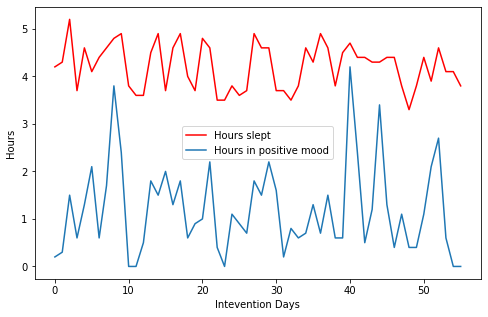

In [7]:
sleep_list = []
positive_list = []

for run in range(0, runs):
    
    env1 = Patient(behaviour_threshold=20, habituation=habituation, time_preference_update_step=time_preference_update_step )
    action = [0,0,0,0]
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        # print(observation)
        action = [0,0,0,0]
    
    
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

# Intervention

In [8]:
def intervention(method, runs, name, condition):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    for run in range(0, runs):

        env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step)
        env1 = method(env1)
        if sum(env1.num_performed):
            performed += 1
        df = pd.DataFrame()
        df['responce_ratio'] = env1.rr
        df['activity performed'] = env1.num_performed
        df['notifications'] = env1.num_notified
        df['sleep'] = env1.h_slept
        df['positive'] = env1.h_positive
        df['non_stationary'] = env1.h_nonstationary
        
        df.to_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory, condition, name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
    ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
    ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
    ax2.set_xlabel('Intervention Days')
    ax2.set_ylabel('No. notifications')
    ax1.set_ylabel('Responce ratio')
    plt.show()
    return sleep_list, positive_list, rr_random_list, not_random_list

## Heuristic

Notify every hour except in night and when the patinets is alseep

In [9]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = [0,0,0,0]
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[10] == 3 or observation[3] ==1:
            action = [0,0,0,0]
        else:
            action = [1,0,0,0]
            
    return env1

This figures include runs in which no prompt resulted in the activity being performed
1 out of 10 resulted in activity being performed 


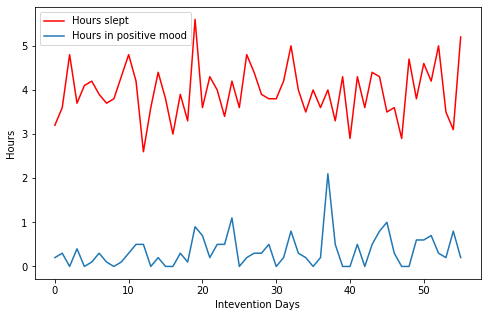

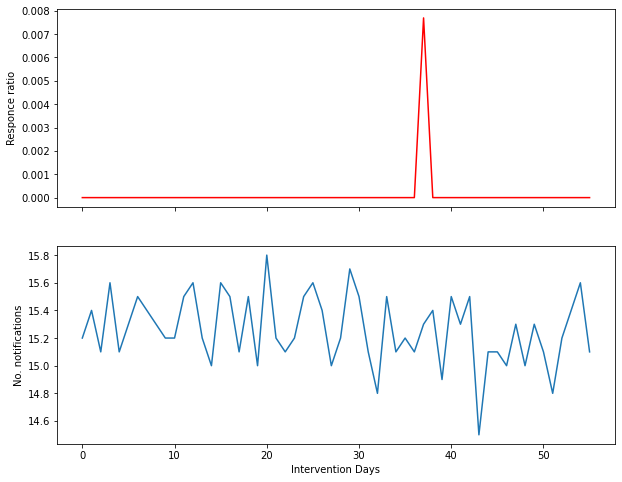

In [10]:
sleep_listh, positive_listh, rr_h_list, not_h_list = intervention(always_notify, runs, 'h', condition)

## Random 
Randomly sample during the day skip the nights

In [11]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = [0,0,0,0]
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] ==3:
            action = [0,0,0,0]
        else:
            action = env1.action_space.sample()
#             print(action)
            
    return env1

This figures include runs in which no prompt resulted in the activity being performed
10 out of 10 resulted in activity being performed 


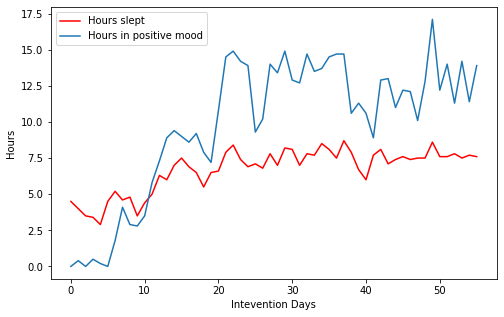

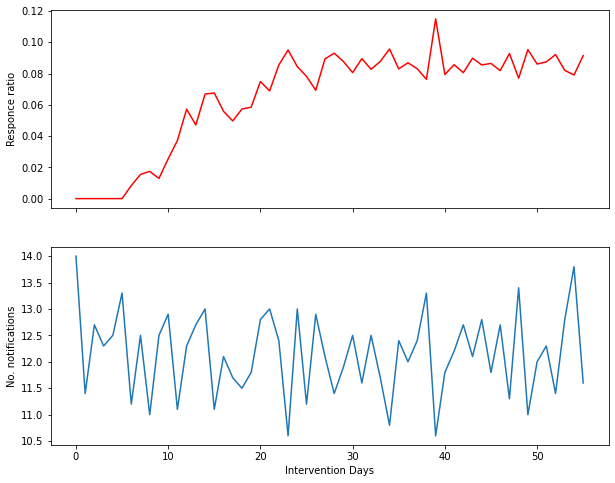

In [12]:
_ = intervention(random_notification, runs, 'random', condition)

In [13]:
def get_rr_and_notification(name, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient1_{1}_{2}_run{3}.csv".format(results_directory,condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.responce_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print(" {0} out of {1} runs had no activity performed throught the full intervention.".format(failed, runs))
    return rr, noti, failed

In [14]:
rr_random_list, not_random_list, fppo = get_rr_and_notification('random', runs, condition)

 0 out of 10 runs had no activity performed throught the full intervention.


## Supervised Learning

### static model

In [15]:
def supervised_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = random_notification(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    # print(env1.selected_actions)
    clf.fit(env1.observation_list, env1.selected_actions)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        # print(action)
        observation, reward, done, info = env1.step(action)
        
        
    return env1

This figures include runs in which no prompt resulted in the activity being performed
10 out of 10 resulted in activity being performed 


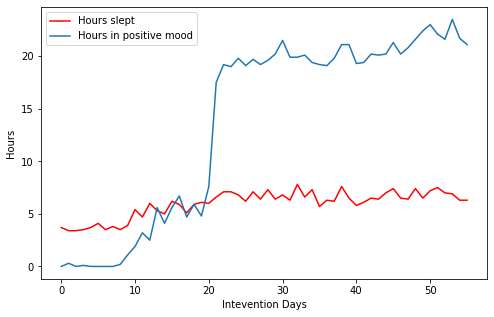

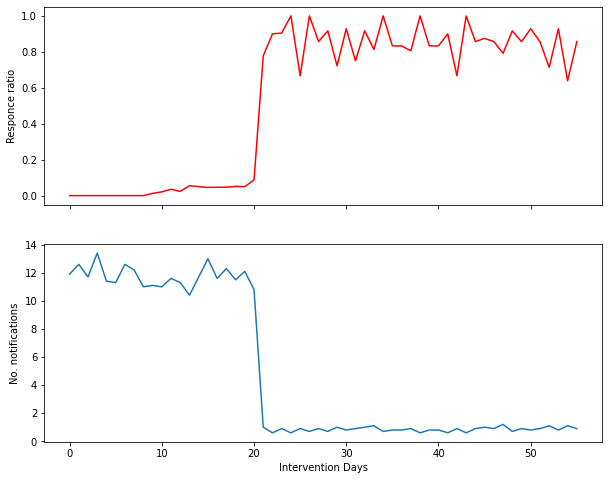

In [16]:
_ =intervention(supervised_after_three_weeks,runs , 'static_sup3', condition)

### adaptive model 

In [17]:
def supervised_adaptive_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = random_notification(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.selected_actions)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.selected_actions)
            samples = len(env1.observation_list)
            
        
    return env1

This figures include runs in which no prompt resulted in the activity being performed
10 out of 10 resulted in activity being performed 


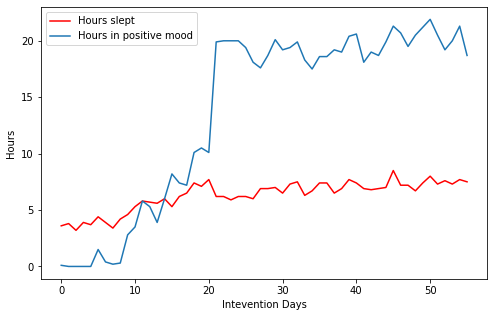

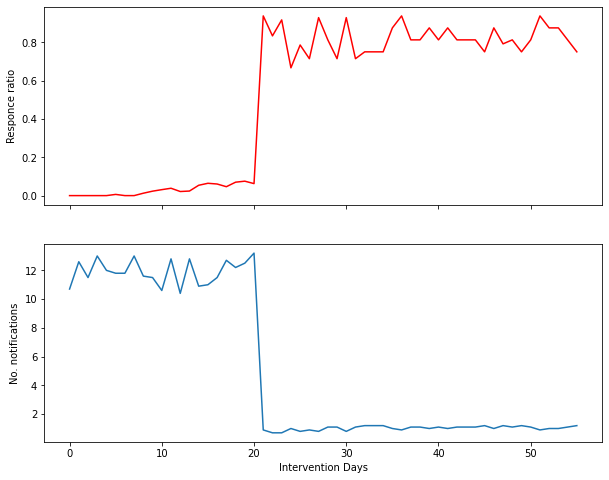

In [18]:
_ = intervention(supervised_adaptive_after_three_weeks, runs, 'adaptive_sup3', condition)

### How many times supervised training faild?

In [19]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup3', runs, condition)

 0 out of 10 runs had no activity performed throught the full intervention.


In [20]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup3', runs, condition)

 0 out of 10 runs had no activity performed throught the full intervention.


## Deep Q Network

In [29]:
#  does not support multi discreate actions!!

In [23]:
def dqn(env1):
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

In [24]:
_= intervention(dqn, 1, 'dqn', condition)

AssertionError: The algorithm only supports (<class 'gym.spaces.discrete.Discrete'>,) as action spaces but MultiDiscrete([2 4 4 3]) was provided

In [23]:
rr_dqn_list, not_dqn_list, fdqn = get_rr_and_notification('dqn', runs, condition)

 1 out of 1 runs had no activity performed throught the full intervention.


## Proximal Policy Optimisation

In [25]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day, batch_size=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
10 out of 10 resulted in activity being performed 


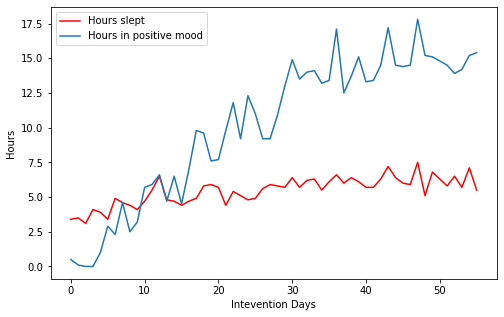

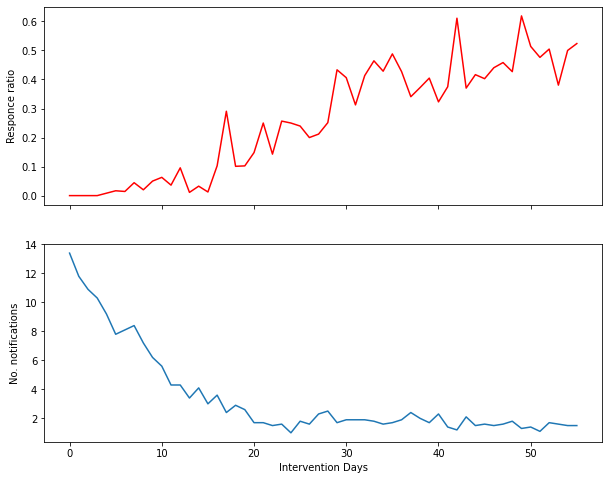

In [27]:
_= intervention(ppo, runs, 'ppo', condition)

In [28]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 0 out of 10 runs had no activity performed throught the full intervention.


## Advantage Actor Critic

In [30]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

This figures include runs in which no prompt resulted in the activity being performed
10 out of 10 resulted in activity being performed 


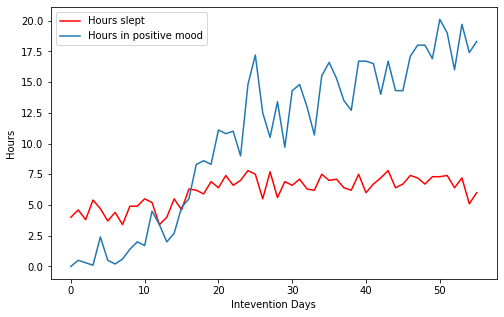

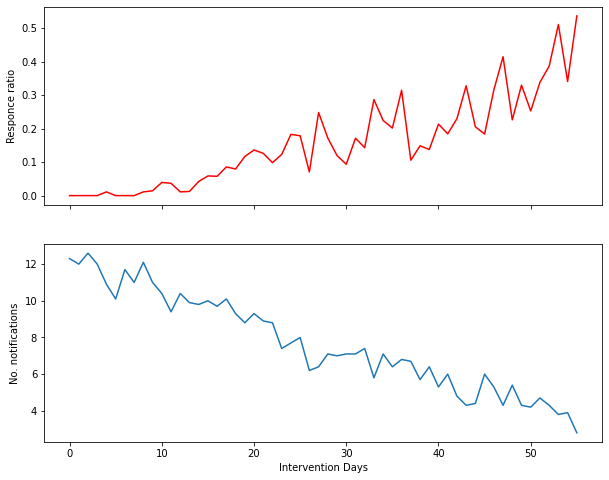

In [31]:
_ = intervention(a2c, runs, 'a2c', condition)

In [32]:
rr_a2c_list, not_a2c_list, fppo = get_rr_and_notification('a2c', runs, condition)

 0 out of 10 runs had no activity performed throught the full intervention.


## Comparison between prompt learning stategies

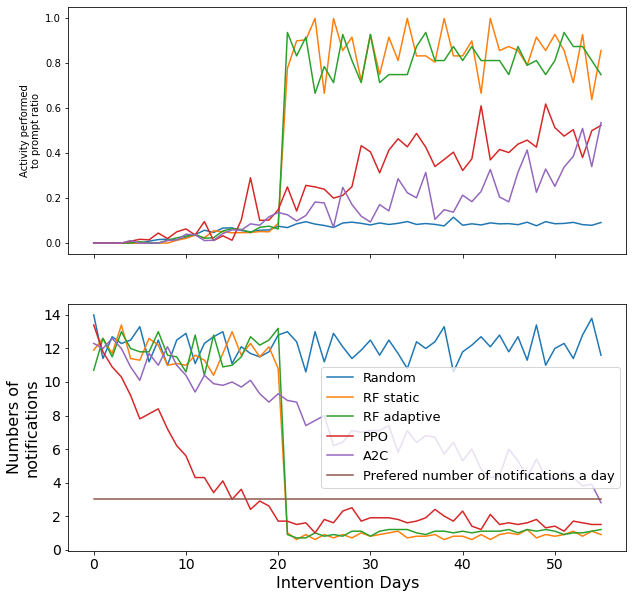

In [34]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
# ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')


ax2.plot(np.nanmean(not_random_list, axis=0), label='Random')
ax2.plot(np.nanmean(not_rf3_list, axis=0), label='RF static')
ax2.plot(np.nanmean(not_rf3a_list, axis=0), label='RF adaptive')
# ax2.plot(np.nanmean(not_dqn_list, axis=0), label='DQN')
ax2.plot(np.nanmean(not_ppo_list, axis=0), label='PPO')
ax2.plot(np.nanmean(not_a2c_list, axis=0), label='A2C')
ax2.plot(np.ones(len(np.mean(not_random_list, axis=0))) +2, label ='Prefered number of notifications a day')

ax2.set_xlabel('Intervention Days', fontsize=16)
ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
# ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
# plt.ylim(0, 0.95)
ax2.legend(fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Plots

In [35]:
runs =1
#basic stable condition
condition = 'stable'

#Other options:
# condition = 'habituated'
# condition = 'changed_preference'
# condition = 'habituated_changed_preference'

In [36]:
rr_rf3_list, not_rf3_list, frf3 = get_rr_and_notification('static_sup3', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [37]:
rr_rf3a_list, not_rf3a_list, frf3a = get_rr_and_notification('adaptive_sup3', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [38]:
rr_dqn_list, not_dqn_list, fdqn = get_rr_and_notification('dqn', runs, condition)

 1 out of 1 runs had no activity performed throught the full intervention.


In [39]:
rr_ppo_list, not_ppo_list, fppo = get_rr_and_notification('ppo', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [40]:
rr_a2c_list, not_a2c_list, fa2c = get_rr_and_notification('a2c', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [41]:
rr_random_list, not_random_list, frandom = get_rr_and_notification('random', runs, condition)

 0 out of 1 runs had no activity performed throught the full intervention.


In [42]:
shift = 7* 5

In [43]:
intervention_length = 7*8

C:\Users\AnetaLisowska\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AnetaLisowska\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
C:\Users\AnetaLisowska\Anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


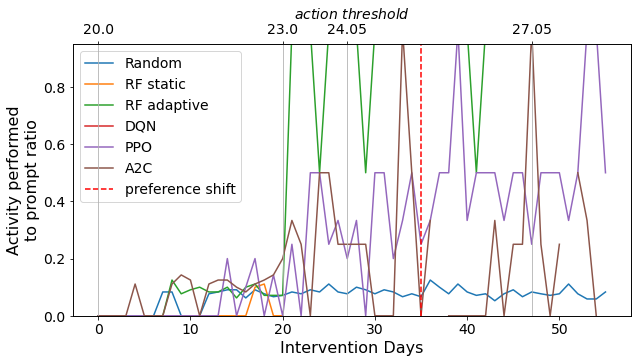

In [44]:
fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10,5))
ax1.plot(np.nanmean(rr_random_list, axis=0), label='Random')
ax1.plot(np.nanmean(rr_rf3_list, axis=0), label='RF static')
ax1.plot(np.nanmean(rr_rf3a_list, axis=0), label='RF adaptive')
ax1.plot(np.nanmean(rr_dqn_list, axis=0), label='DQN')
ax1.plot(np.nanmean(rr_ppo_list, axis=0), label='PPO')
ax1.plot(np.nanmean(rr_a2c_list, axis=0), label='A2C')
ax1.vlines(shift , 0, 1, linestyles='dashed', color='red', label='preference shift' )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2 = ax1.twiny()
def tick_function(X):
    V = 20 + 0.15 * X
    return V

new_tick_locations = np.array([0, 20, 27, 47])
ax2.grid(True)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel('$ \it{action}$ $\it{threshold}$', fontsize=14 )
ax1.set_xlabel('Intervention Days', fontsize=16 )
ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)), fontsize=16 )
plt.ylim(0, 0.95)
ax1.legend( fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Intervention vs. No Intervention

Simulated patients who habituate to prompts and changes preference to be notified in the evening after 5 weeks of intervention

In [ ]:
habituation=False
time_preference_update_step= 99999999
condition = 'habituated_changed_preference'

In [ ]:
sleep_list = []
positive_list = []
walking_list = []

for run in range(0, runs):
    
    env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step)
    action = 0
    for i in  range(eight_weeks):
        
        observation , reward, done, info = env1.step(action)
        action = 0
        
    sleep_list.append(env1.h_slept)
    positive_list.append(env1.h_positive)
    walking_list.append(env1.h_nonstationary)

fig = plt.figure( figsize=(8, 5))
plt.plot(np.nanmean(sleep_list, axis=0), label='Hours slept', color ='r')
plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
plt.plot(np.mean(walking_list, axis=0), label='Hours active')
plt.ylabel('Hours ')
plt.xlabel('Intevention Days')
plt.legend()
plt.show()

In [ ]:
def get_patient_state_progress(condition, name, runs):
    
    walking = []
    sleeping = []
    positive = []
    for run in range(runs):
        df = pd.read_csv('{3}/patient1_{0}_{1}_run{2}.csv'.format(condition, name, run, results_directory))
        a_performed = sum(df['activity performed'].values)
        if a_performed >0:
            walking.append(df.non_stationary)
            sleeping.append(df.sleep)
            positive.append(df.positive)
    return walking, sleeping, positive
    

In [ ]:
walkingh, sleep_listh, positive_listh = get_patient_state_progress(condition, 'h', runs)

In [ ]:
walking_ppo, sleep_list_ppo, positive_list_ppo = get_patient_state_progress(condition, 'ppo', runs)

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(16, 4))
ax[0].plot(np.nanmean(sleep_list, axis=0), label='Slept', color ='r')
ax[0].plot(np.mean(positive_list, axis=0), label='In positive mood')
ax[0].plot(np.mean(walking_list, axis=0), label='Non-stationary activity')
ax[1].plot(np.nanmean(sleep_listh, axis=0), label='Hours slept', color ='r')
ax[1].plot(np.mean(positive_listh, axis=0), label='Hours in positive mood')
ax[1].plot(np.mean(walkingh, axis=0), label='Active')
ax[2].plot(np.nanmean(sleep_list_ppo, axis=0), label='Hours slept', color ='r')
ax[2].plot(np.mean(positive_list_ppo, axis=0), label='Hours in positive mood')
ax[2].plot(np.mean(walking_ppo, axis=0), label='Active')
ax[0].set_ylabel('Hours', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Intevention Days', fontsize=14)
ax[1].set_xlabel('Intevention Days', fontsize=14)
ax[2].set_xlabel('Intevention Days', fontsize=14)
ax[0].set_title('No intervention', fontsize=14)
ax[1].set_title('Intervention with hourly prompts', fontsize=14)
ax[2].set_title("Intervention with 'timely' prompts", fontsize=14)